In [1]:
# import of standard python libraries
import lenstronomy
import numpy as np
import corner
import matplotlib.pyplot as plt
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
import h5py
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

C:\Users\Dell\AppData\Local\Temp\ipykernel_10096\1467123943.py:9: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


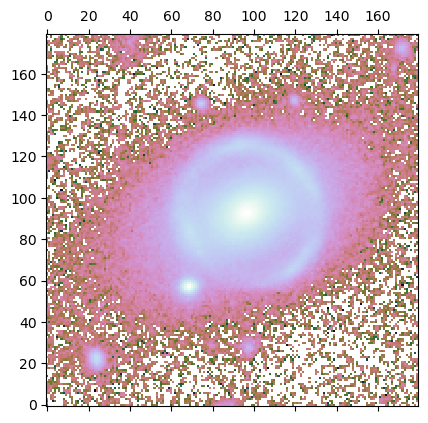

In [2]:
# data specifics
with h5py.File('DESIJ1101-0602_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
        
image_data = kwargs_data['image_data']
kwargs_data
plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');

In [3]:
with h5py.File('psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
        
kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [5]:
lens_model_list = ["EPL", "SHEAR"]


source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
# beta, n_max, center_x, center_y


lens_light_model_list = ["SERSIC_ELLIPSE"]

C:\Users\Dell\AppData\Local\Temp\ipykernel_10096\864943256.py:102: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)
C:\Users\Dell\AppData\Local\Temp\ipykernel_10096\864943256.py:102: RuntimeWarning: invalid value encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


Text(0.5, 1.0, 'IMAGE AFTER MASKING')

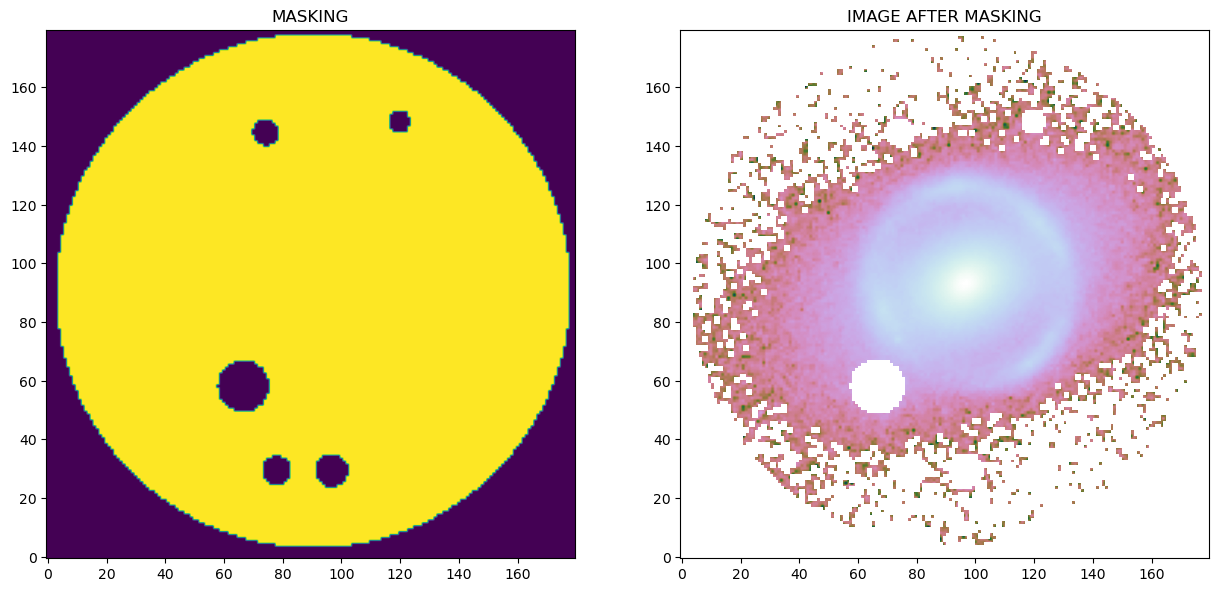

In [6]:


# To make a mask using lenstronomy functions, here is an example code:

from lenstronomy.Util import mask_util
from lenstronomy.Util import util

from lenstronomy.Data.coord_transforms import Coordinates


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, 
                     ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 7 # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

# mask_outer_2 = mask_util.mask_center_2d(
#     lens_center_ra,
#     lens_center_dec,
#     r2,
#     util.image2array(x_coords),
#     util.image2array(y_coords),)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.9,
    lens_center_dec - 2.6,
    0.7,
    0.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.34,
    lens_center_dec + 4.6,
    0.3,
    0.3,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3,
    lens_center_dec + 4.3,
    0.35,
    0.35,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5 ,
    lens_center_dec - 4.9,
    0.45,
    0.45,
    0,
)
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1 ,
    lens_center_dec - 4.9,
    0.4,
    0.4,
    0,
)

mask_1 = (1 - mask_outer_1) * (1 - mask_ext_1) 
mask_2 = (1 - mask_ext_2) * (1 - mask_ext_3) 
mask_3 = (1 - mask_ext_4) *  (1 - mask_ext_5)
mask1 = mask_1 * mask_2 *  mask_3
mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0



mask_img = mask1.reshape(num_pix, num_pix)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))


image = np.log10(kwargs_data["image_data"] * mask_img)


plt.sca(axs[0])
plt.imshow(mask_img, origin="lower")
plt.title("MASKING")
# plt.colorbar()




# plt.matshow(np.log10(image), origin="lower", cmap="cubehelix")


plt.sca(axs[1])
plt.imshow(image , origin="lower", cmap="cubehelix")
plt.title("IMAGE AFTER MASKING")



In [7]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Setting EPL Parameters

fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 1.3, 'gamma': 2., 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': .2, 'gamma': .1, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 1., 'e1': -0.5,
                          'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 'gamma': 3., 'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10})


# Setting SHEAR Parameters

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})


lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens, 
               kwargs_upper_lens,
              ] 

In [8]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 
                     'e2': 0,'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 
                    'e2': 0.05,'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001,
                 'n_sersic': .5 ,'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 
                'n_sersic': 5.,'center_x': 10, 'center_y': 10, 'amp': 100})

joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]

lens_light_params = [kwargs_lens_light_init, 
                     kwargs_lens_light_sigma, 
                     fixed_lens_light,
                     kwargs_lower_lens_light,
                     kwargs_upper_lens_light,
                    ]


In [9]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({'n_sersic': 1.})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0,
                  'e2': 0,'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05,
                            'e2': 0.05,'center_x': 0.2, 'center_y': 0.2,
                            'amp': 10})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 
            'n_sersic': .5, 'center_x': -10, 'center_y': -10,'amp': 0})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10,  
        'n_sersic': 5.,  'center_x': 10, 'center_y': 10, 'amp': 100})


# add shapelets model to this source model
fixed_source.append({'n_max': 6})
kwargs_source_init.append({'beta': 0.05, 'center_x': 0., 'center_y': 0.})
kwargs_source_sigma.append({'beta': 0.1, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'beta': 0.001, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'beta': 0.2, 'center_x': 10, 'center_y': 10})

joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]

source_params = [kwargs_source_init, 
                 kwargs_source_sigma, 
                 fixed_source, 
                 kwargs_lower_source,
                 kwargs_upper_source,
                ]



In [14]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params,
                }

kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light,
                      "joint_source_with_source": joint_source_with_source,
                     }
kwargs_likelihood = {'check_bounds': True, 
                     'image_likelihood_mask_list':  [mask_img],
                    }

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False,
                   }
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
               }

multi_band_list = [[kwargs_data,
                    kwargs_psf,
                    kwargs_numerics,
                   ]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band',
                    }

In [ ]:
# 
from lenstronomy.Workflow.fitting_sequence import FittingSequence



fitting_kwargs_list = [["PSO", {"sigma_scale": 1.0, 
                                "n_particles": 700, 
                                "n_iterations": 100}]]
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}] 

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True, 
    )

input_ = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params, 
    ]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output_ = [kwargs_result,
           multi_band_list_out,
           fit_output, 
           kwargs_fixed_out,
          ]




# fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
            #kwargs_constraints, kwargs_likelihood, kwargs_params)

# fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 400,
                                #'n_iterations': 700}],
                       # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
                       # 200, 'sigma_scale': .1}]]

# chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
# kwargs_result = fitting_seq.best_fit()

-0.8232365875239611 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8232365875239612


E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
C:\Users\Dell\AppData\Local\Temp\ipykernel_13728\3954802610.py:20: UserWarning: Tight layout not applied. t

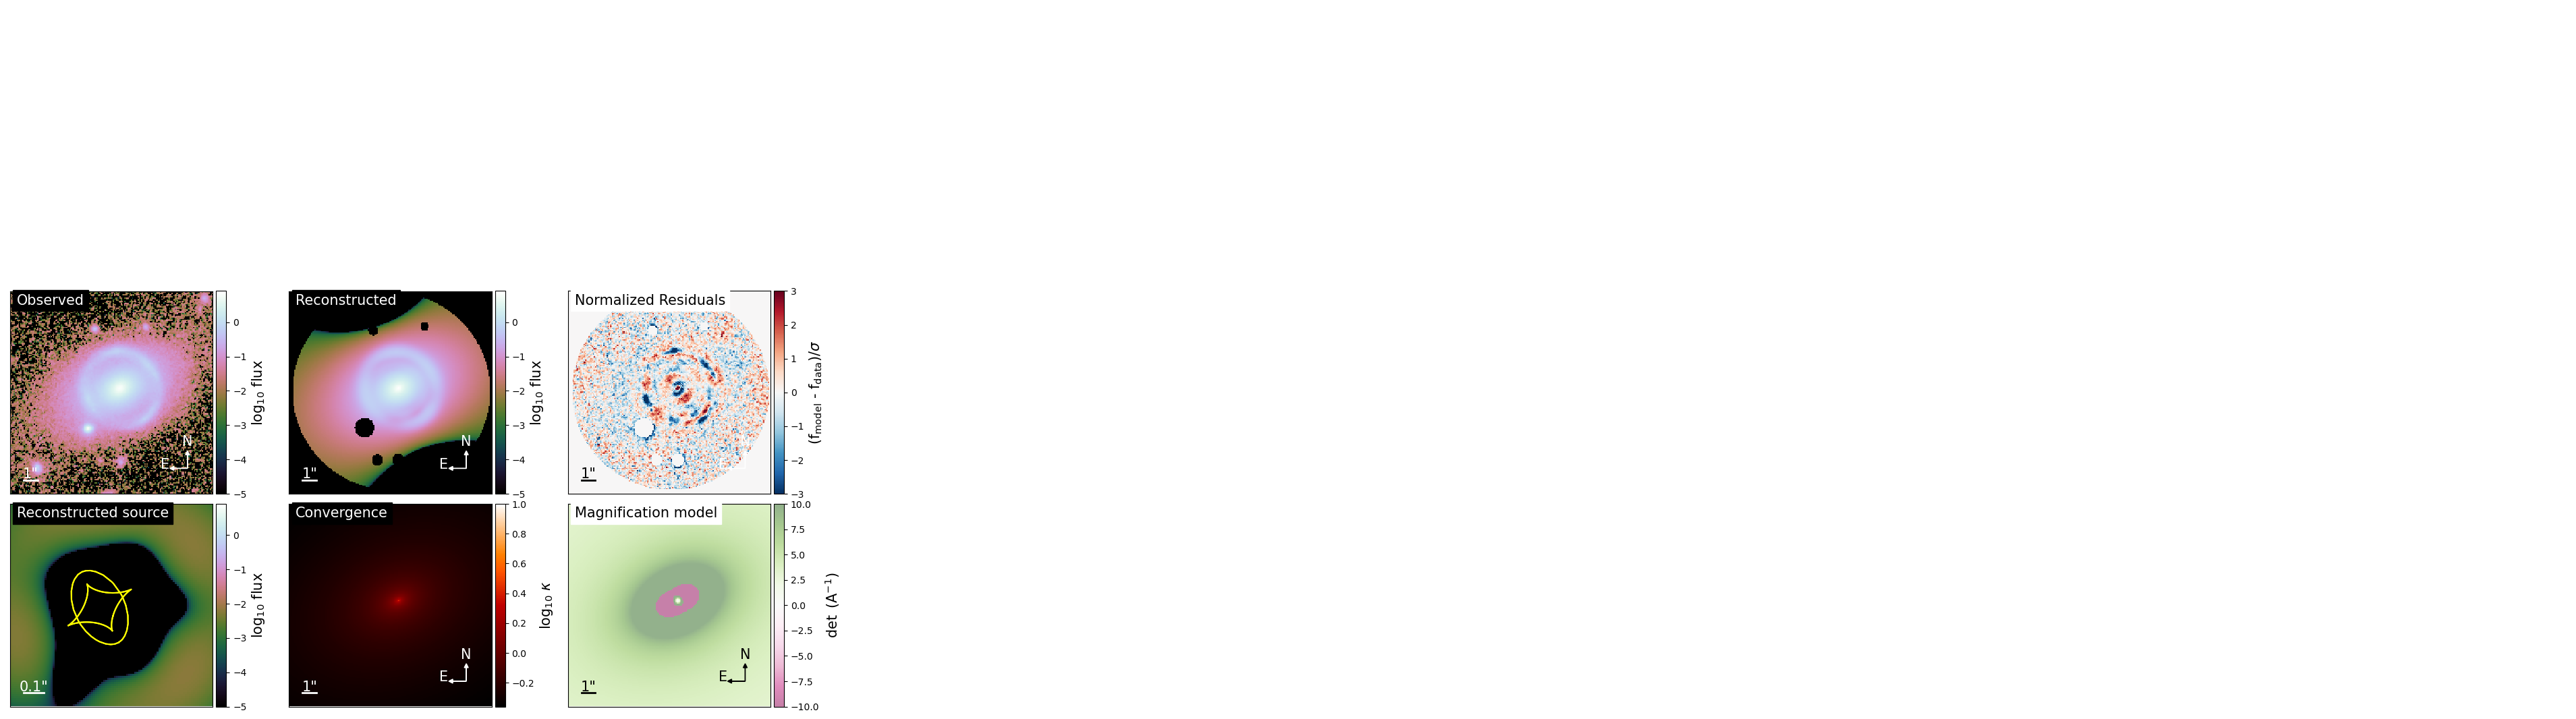

E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


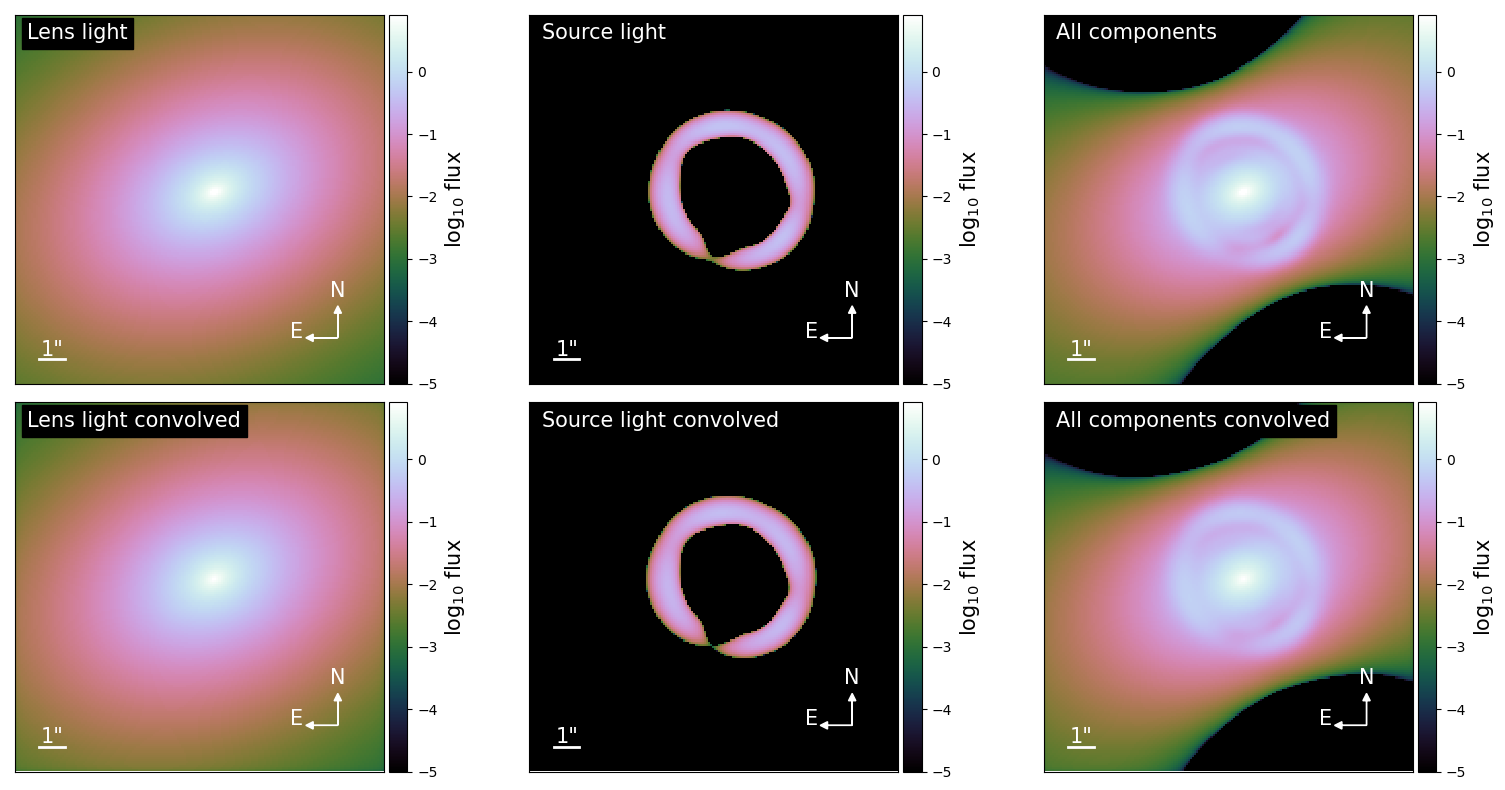

In [16]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 
                       3,
                       figsize=(16, 8),
                       sharex=False, 
                       sharey=False,
                      )

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2],
                                    v_min=-3, 
                                    v_max=3, 
                                    cmap="RdBu_r",
                                   )
model_plot.source_plot(ax=axes[1, 0],
                       deltaPix_source=0.01,
                       numPix=100, 
                       with_caustics=True,
                      )
model_plot.convergence_plot(ax=axes[1, 1],
                            v_max=1, 
                            cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], 
                              cmap="PiYG",
                             )
f.tight_layout()
f.subplots_adjust(left=None, 
                  bottom=None,
                  right=None, 
                  top=None, 
                  wspace=0.0,
                  hspace=0.05,
                 )
plt.show()

f, axes = plt.subplots(2, 
                       3,
                       figsize=(16, 8), 
                       sharex=False, 
                       sharey=False,
                      )

model_plot.decomposition_plot(ax=axes[0, 0], 
                              text="Lens light", 
                              lens_light_add=True, 
                              unconvolved=True,
                             )
model_plot.decomposition_plot(ax=axes[1, 0],
                              text="Lens light convolved",
                              lens_light_add=True,
                             )
model_plot.decomposition_plot(ax=axes[0, 1], 
                              text="Source light", 
                              source_add=True, 
                              unconvolved=True )
model_plot.decomposition_plot( ax=axes[1, 1],
                              text="Source light convolved", 
                              source_add=True,
                             )
model_plot.decomposition_plot(ax=axes[0, 2],
                              text="All components",
                              source_add=True,
                              lens_light_add=True,
                              unconvolved=True,
                             )
model_plot.decomposition_plot( ax=axes[1, 2],
                              text="All components convolved",
                              source_add=True,
                              lens_light_add=True,
                              point_source_add=True, 
                             )
f.tight_layout()
f.subplots_adjust(left=None, bottom=None,
                  right=None, top=None,
                  wspace=0.0, hspace=0.05)
plt.show()